In [17]:
# Import some useful modules
import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import re
from sklearn import ensemble
from sklearn import metrics
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold

/Users/chuanlong/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/chuanlong/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [18]:
# Load the file as dataframe
file_path = '/Users/chuanlong/GitHub/Tandon_Torch/data/train.json'
df = pd.read_json(file_path);

In [19]:
# This Method include the pipeline to clean the dataset
def clean_data(df):
    # Filter the building id outlier
    outlier_filter_buildingid = (df.building_id != '0')
    df = df[outlier_filter_buildingid]
    # Filter the price outlier
    outlier_filter_price = (500 < df.price) & (df.price < 8000)
    df = df[outlier_filter_price]
    # Filter the null listing id
    df = df[df.listing_id.isnull() == False]
    # Filter the position outlier
    outlier_filter_longitude = (df.longitude > -74.2) & (df.longitude < -73.6)
    df = df[outlier_filter_longitude]
    outlier_filter_latitude = (df.latitude > 40.0) & (df.latitude < 41.0) 
    df = df[outlier_filter_latitude]
    return df

In [20]:
# This method transform the Created timeframe to days
def transformCreatedTime(df, attribute):
    current_time = pd.to_datetime('2017-01-01')
    df[attribute] = df[attribute].map(lambda x : current_time - pd.to_datetime(x))\
                                 .map(lambda x : x / np.timedelta64(1, 's'))\
                                 .map(lambda x : float(x) / (60 * 60 * 24))
    return df[attribute]

In [21]:
def create_features(df):
    def word_stem(s):
        if type(s) == str:
            s = s.lower()
            s = s.strip()
            s = s.replace('/', ' ')
            s = s.replace(':', ' ')
            s = s.replace('&', ' ')
            s = s.replace('-', ' ')
            s = re.sub(r'[!]+', '', s)
            return s
        else:
            return None
    def list_stem(features):
        if len(features) > 0:
            s = ''
            for i in range(len(features)):
                features[i] = word_stem(features[i])
                s += ' ' + features[i]
            return s
        else:
            return ''
    df['features'] = df['features'].map(lambda x: list_stem(x))
    df['doorman'] = df['features'].map(lambda x: 1 if 'doorman' in x else 0)
    df['elevator'] = df['features'].map(lambda x: 1 if 'elevator' in x else 0)
    df['laundry'] = df['features'].map(lambda x: 1 if 'laundry' in x else 0)
    df['hardwood'] = df['features'].map(lambda x: 1 if 'hardwood' in x else 0)
    df['fitness'] = df['features'].map(lambda x: 1 if 'fitness' in x else 0)
    df['pets'] = df['features'].map(lambda x: 1 if 'cats' in x or 'dogs'in x else 0)
    df['dishwasher'] = df['features'].map(lambda x: 1 if 'dishwasher' in x else 0)
    df['no_fee'] = df['features'].map(lambda x: 1 if 'no fee' in x else 0)
    df['weighted_features'] = df.doorman * 0.12 + df.elevator * 0.15\
                            + df.laundry * 0.16 + df.hardwood * 0.16\
                            + df.fitness * 0.1 + df.pets * 0.22\
                            + df.dishwasher * 0.16 + df.no_fee * 0.22
    return df

In [22]:
# This method is to preprocess the dataset, you will all set if you call it
def preprocess_data(df):
    df = clean_data(df)
    df.created = transformCreatedTime(df, 'created')
    df = create_features(df)
    return df

In [23]:
df = preprocess_data(df)
df

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,street_address,doorman,elevator,laundry,hardwood,fitness,pets,dishwasher,no_fee,weighted_features
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,190.670556,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,,medium,40.7145,7211212,...,792 Metropolitan Avenue,0,0,0,0,0,0,0,0,0.00
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,202.486493,,Columbus Avenue,doorman elevator fitness center cats allowed ...,low,40.7947,7150865,...,808 Columbus Avenue,1,1,0,0,1,1,0,0,0.59
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,258.856470,"Top Top West Village location, beautiful Pre-w...",W 13 Street,laundry in building dishwasher hardwood floor...,high,40.7388,6887163,...,241 W 13 Street,0,0,1,1,0,0,1,0,0.48
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,257.901366,Building Amenities - Garage - Garden - fitness...,East 49th Street,hardwood floors no fee,low,40.7539,6888711,...,333 East 49th Street,0,0,0,1,0,0,0,1,0.38
100014,2.0,4,38a913e46c94a7f46ddf19b756a9640c,256.816123,,West 18th Street,,medium,40.7429,6894514,...,350 West 18th Street,0,0,0,0,0,0,0,0,0.00
100016,1.0,2,3ba49a93260ca5df92fde024cb4ca61f,248.861157,Stunning unit with a great location and lots o...,West 107th Street,prewar elevator dogs allowed cats allowed low...,low,40.8012,6930771,...,210 West 107th Street,0,1,0,1,0,1,0,1,0.75
100020,2.0,1,0372927bcb6a0949613ef5bf893bbac7,262.748819,"This huge sunny ,plenty of lights 1 bed/2 bath...",West 21st Street,doorman elevator pre war terrace laundry in u...,low,40.7427,6867392,...,155 West 21st Street,1,1,1,1,0,0,1,0,0.75
100026,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,255.891262,<p><a website_redacted,Hamilton Terrace,cats allowed dogs allowed elevator laundry in...,medium,40.8234,6898799,...,63 Hamilton Terrace,0,1,1,0,0,1,0,0,0.53
100044,1.0,2,67c9b420da4a365bc26a6cd0ef4a5320,256.765683,***LOW FEE. Beautiful CHERRY OAK WOODEN FLOORS...,E 38th St,doorman elevator laundry in building no fee,high,40.7488,6895442,...,137 E 38th St,1,1,1,0,0,0,0,1,0.65
100051,1.0,0,bfb9405149bfff42a92980b594c28234,257.891667,Stunning full renovated studio unit. High cei...,East 34th Street,doorman elevator fitness center laundry in bu...,medium,40.7439,6889043,...,340 East 34th Street,1,1,1,0,1,0,0,1,0.75


In [26]:
# Preprocess the train dataset
# columns = ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', 'created', 'doorman', 'elevator', 'laundry', 'hardwood', 'fitness', 'pets', 'dishwasher', 'no_fee', 'interest_level']
columns = ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', 'created', 'weighted_features', 'interest_level']
# df = preprocess_data(df)
train_data = df[columns]
train_data

,bathrooms,bedrooms,latitude,longitude,price,created,weighted_features,interest_level
10,1.5,3,40.7145,-73.9425,3000,190.670556,0.00,medium
10000,1.0,2,40.7947,-73.9667,5465,202.486493,0.59,low
100004,1.0,1,40.7388,-74.0018,2850,258.856470,0.48,high
100007,1.0,1,40.7539,-73.9677,3275,257.901366,0.38,low
100014,2.0,4,40.7429,-74.0028,7995,256.816123,0.00,medium
100016,1.0,2,40.8012,-73.9660,3600,248.861157,0.75,low
100020,2.0,1,40.7427,-73.9957,5645,262.748819,0.75,low
100026,1.0,1,40.8234,-73.9457,1725,255.891262,0.53,medium
100044,1.0,2,40.7488,-73.9770,3000,256.765683,0.65,high
100051,1.0,0,40.7439,-73.9743,2350,257.891667,0.75,medium


### Feature Engineering Experiment

In [27]:
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
X, y = train_data.drop('interest_level', 1), train_data.interest_level
forest.fit(X, y)
importances = forest.feature_importances_

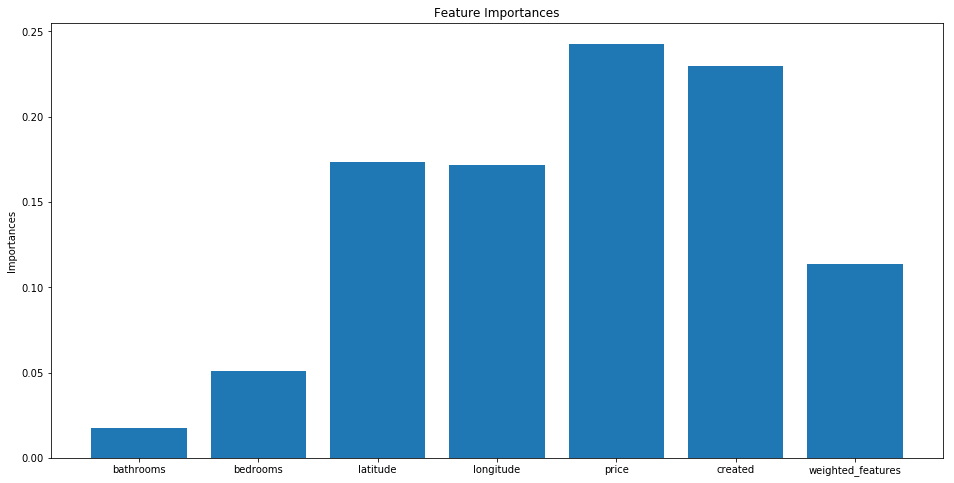

In [30]:
# Plot the Picture for the feature importances
plt.figure(figsize=(16,8))
plt.bar(np.arange(7), forest.feature_importances_)
plt.xticks(np.arange(7), columns)
plt.ylabel('Importances')
plt.title('Feature Importances')
plt.show()

### Model Training

* Should use the grid search
* Should test other models
* How could you measure the training progress?

In [ ]:
def log_loss_score(true_label, predict_label):
    return metrics.log_loss(true_label, predict_label)

In [ ]:
def train_model(train_data, test_data, params):
    # Should use the grid search
    params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 1.0, 'loss': 'deviance'}
    clf = ensemble.GradientBoostingClassifier(**params)
    X_train, y_train = train_data.drop('interest_level', 1), train_data.interest_level
    X_test, y_test = test_data.drop('interest_level', 1), test_data.interest_level
    clf = clf.fit(X_train, y_train)
    res = clf.predict_proba(X_test)
    score = metrics.log_loss(y_test, res)